In [1]:
import numpy as np
import pandas as pd
import os
import datetime as dt
import matplotlib.pyplot as plt
from sklearn.preprocessing import OneHotEncoder
from sklearn.metrics import mean_squared_error, mean_absolute_error
from sklearn.linear_model import LinearRegression, Lasso
from sklearn.ensemble import RandomForestRegressor
from sklearn.model_selection import KFold, GridSearchCV
from xgboost import XGBRegressor
import seaborn as sns
import warnings
warnings.filterwarnings('ignore')

/Users/taras/opt/anaconda3/lib/python3.8/site-packages/xgboost/compat.py:31: FutureWarning: pandas.Int64Index is deprecated and will be removed from pandas in a future version. Use pandas.Index with the appropriate dtype instead.
  from pandas import MultiIndex, Int64Index


In [2]:
os.chdir('/Users/taras/Documents/mrsool/')

<h2>Read the data</h2>

In [3]:
train_data = pd.read_csv('train.csv')
test_data = pd.read_csv('test.csv')

In [4]:
train_data.columns

Index(['creation_datetime', 'updated_at', 'age_less_than', 'num_apartments',
       'num_bedrooms', 'floor_num', 'num_kitchens', 'closed',
       'commercial_or_residential', 'property_type', 'driver_room', 'duplex',
       'family_or_single', 'furnished', 'num_living_rooms', 'maid_room',
       'price_per_meter', 'advertiser_type', 'pool', 'paid', 'price',
       'rent_period', 'num_rooms', 'area', 'street_direction', 'street_width',
       'for_rent_or_sale', 'num_water_cycles', 'Latitude', 'Longitude',
       'region_name_en', 'nearest_city_name_en', 'district_name_en'],
      dtype='object')

In [5]:
train_data.head()

,creation_datetime,updated_at,age_less_than,num_apartments,num_bedrooms,floor_num,num_kitchens,closed,commercial_or_residential,property_type,...,area,street_direction,street_width,for_rent_or_sale,num_water_cycles,Latitude,Longitude,region_name_en,nearest_city_name_en,district_name_en
0,2016-03-04 13:49:48,2016-06-02 07:07:34,0,1,4,0,1,مغلق,غير محدد,فيلا,...,297,شمال,15,للبيع,5,24.8402,46.7528,Riyadh,AR RIYADH,Al Munsiyah
1,2016-02-21 23:35:44,2016-02-25 12:19:14,0,0,0,0,0,مغلق,سكني,أرض,...,450,شمال,20,للبيع,0,24.6175,46.5280,Riyadh,UBAYR,Dhahrat Laban
2,2016-01-05 21:26:47,2016-03-05 18:25:43,0,0,5,0,1,مغلق,غير محدد,فيلا,...,750,شرق,20,للبيع,5,24.8131,46.5991,Riyadh,AL WUSAYL,Al Malqa
3,2016-02-04 09:29:46,2016-02-04 09:29:58,0,0,1,0,1,مغلق,غير محدد,فيلا,...,500,شمال,5,للبيع,1,24.6738,46.7369,Riyadh,AR RIYADH,Al Malaz
4,2016-03-28 13:22:12,2016-05-31 16:37:40,4,0,3,2,1,مغلق,غير محدد,شقة,...,0,شمال غربي,35,للإيجار,3,24.8279,46.6451,Riyadh,AD DIR'IYAH,Al Yasmin


<h2>Inappropriate data removal</h2>

In [6]:
train_data['floor_num'].value_counts()

 0     59713
 1      9573
 2      7007
 3      3390
 4       136
 5        40
 20       22
 10       21
 6        16
 8        12
 7        10
 12        9
 9         7
 15        5
 17        3
-1         3
 14        2
 16        2
 13        2
 11        1
 18        1
Name: floor_num, dtype: int64

In [7]:
train_data.loc[train_data['floor_num'] == -1]

,creation_datetime,updated_at,age_less_than,num_apartments,num_bedrooms,floor_num,num_kitchens,closed,commercial_or_residential,property_type,...,area,street_direction,street_width,for_rent_or_sale,num_water_cycles,Latitude,Longitude,region_name_en,nearest_city_name_en,district_name_en
9602,2015-05-12 20:00:19,2015-05-14 08:38:18,2,0,0,-1,0,مغلق,غير محدد,مكتب تجاري,...,555,شرق,30,للإيجار,0,24.7252,46.8225,Riyadh,AR RIYADH,An Nasim Al Gharbi
42351,2015-05-12 19:58:43,2015-05-14 08:38:26,-1,0,0,-1,0,مغلق,سكني,أرض,...,255,شمال,0,للبيع,0,24.7252,46.8225,Riyadh,AR RIYADH,An Nasim Al Gharbi
56672,2015-04-29 16:51:01,2015-04-29 16:51:01,-1,0,3,-1,3,مغلق,غير محدد,استراحة,...,555,غير محدد,0,للإيجار,3,24.6970,46.8453,Riyadh,AR RIYADH,As Saadah


<p>Looks like there are 3 records with very strange data. As it's a small amount and all of them are closed we can remove them.</p>

In [8]:
train_data = train_data.loc[train_data['floor_num'] != -1]
test_data = test_data.loc[test_data['floor_num'] != -1]

<h2>Process data</h2>

<p>Convert strings to datetimes.</p>
<p>Make variableas binary.</p>
<p>Translate Arabic to English.</p>

In [9]:
duplex_vals = {
    "ليست دوبلكس" : 0,
    "دوبلكس": 1,
}

closed_vals = {
    "مغلق" : 'closed',
    "متاح": 'open',
    "غير منشور": 'not published',
}

com_res_vals = {
    "غير محدد" : 'undefined',
    "سكني": 'residental',
    "تجاري": 'commercial',
    "كلاهما": 'both',
    "4": 'undefined',
    "5": 'undefined',
    "6": 'undefined',
    "7": 'undefined',
}

property_vals = {
    "فيلا" : 'villa',
    "شقة": 'appartment',
    "أرض": 'land',
    "عمارة": 'architecture',
    "دور": 'floor',
    "استراحة": 'lounge',
    "محل": 'shop',
    "بيت": 'house',
    "مكتب تجاري": 'commercial office',
    "مستودع": 'storehouse',
    "مزرعة": 'farm',
    "مخيم": 'camp',
    "قصر": 'castle',
    "غرفة": 'appartment',
}

driver_vals = {
    "لا يوجد غرفة سائق" : 0,
    "غرفة سائق": 1,
}

family_vals = {
    "عزاب" : 0,
    "عوائل": 1,
}

furnished_vals = {
    "لا يوجد اثاث" : 0,
    "مؤثثة": 1,
}

maid_room_vals = {
    "لا يوجد غرفة خادمة" : 0,
    "غرفة خادمة": 1,
}

market_vals = {
    "مالك" : 0,
    "مسوق" : 1,
}

pool_vals = {
    "لا يوجد مسبح" : 0,
    "مسبح" : 1,
}

paid_vals = {
    "مجاني" : 0,
    "مدفوع" : 1,
}

rent_period_vals = {
    "غير محدد" : 'undefined',
    "سنوي": 'annual',
    "يومي": 'daily',
    "شهري": 'monthly',
    "4": 'undefined',
    "5": 'undefined',
    "6": 'undefined',
}

street_direction_vals = {
    "غير محدد" : 'undefined',
    "شمال": 'north',
    "جنوب": 'south',
    "شرق": 'east',
    "غرب": 'west',
    "شمال شرقي": 'northeast',
    "جنوب شرقي": 'southeast',
    "جنوب غربي": 'southwest',
    "شمال غربي": 'northwest',
    "3 شوارع": 'undefined',
    "4 شوارع": 'undefined',
}

rent_sale_vals = {
    "للبيع" : 0,
    "للإيجار": 1,
}

In [10]:
def process(df):
    """
    Translate to english (or make variables binary if it is possible).
    """
    for date_col in ['creation_datetime', 'updated_at']:
        df[date_col] = pd.to_datetime(df[date_col], format='%Y-%m-%d %H:%M:%S')
    
    df['duplex'] = df['duplex'].map(lambda x: duplex_vals.get(x, 0))
    df['closed'] = df['closed'].map(lambda x: closed_vals.get(x, 'closed'))
    df['commercial_or_residential'] = df['commercial_or_residential'].map(lambda x: com_res_vals.get(x, 'undefined'))
    df['property_type'] = df['property_type'].map(lambda x: property_vals.get(x, 'villa'))
    df['driver_room'] = df['driver_room'].map(lambda x: driver_vals.get(x, 0))
    df['family'] = df['family_or_single'].map(lambda x: family_vals.get(x, 0))
    df['furnished'] = df['furnished'].map(lambda x: furnished_vals.get(x, 0))
    df['maid_room'] = df['maid_room'].map(lambda x: maid_room_vals.get(x, 0))
    df['is_market_adv'] = df['advertiser_type'].map(lambda x: market_vals.get(x, 1))
    df['pool'] = df['pool'].map(lambda x: pool_vals.get(x, 0))
    df['paid'] = df['paid'].map(lambda x: paid_vals.get(x, 0))
    df['rent_period'] = df['rent_period'].map(lambda x: rent_period_vals.get(x, 'undefined'))
    df['street_direction'] = df['street_direction'].map(lambda x: street_direction_vals.get(x, 'undefined'))
    df['for_rent'] = df['for_rent_or_sale'].map(lambda x: rent_sale_vals.get(x, 0))

    df.drop(columns=['family_or_single', 'advertiser_type', 'for_rent_or_sale'], inplace=True)
    
    return df

In [11]:
train_data = process(df=train_data)
test_data = process(df=test_data)

<h2>Let's look on the data</h2>

In [12]:
train_data.head()

,creation_datetime,updated_at,age_less_than,num_apartments,num_bedrooms,floor_num,num_kitchens,closed,commercial_or_residential,property_type,...,street_width,num_water_cycles,Latitude,Longitude,region_name_en,nearest_city_name_en,district_name_en,family,is_market_adv,for_rent
0,2016-03-04 13:49:48,2016-06-02 07:07:34,0,1,4,0,1,closed,undefined,villa,...,15,5,24.8402,46.7528,Riyadh,AR RIYADH,Al Munsiyah,0,1,0
1,2016-02-21 23:35:44,2016-02-25 12:19:14,0,0,0,0,0,closed,residental,land,...,20,0,24.6175,46.5280,Riyadh,UBAYR,Dhahrat Laban,0,0,0
2,2016-01-05 21:26:47,2016-03-05 18:25:43,0,0,5,0,1,closed,undefined,villa,...,20,5,24.8131,46.5991,Riyadh,AL WUSAYL,Al Malqa,0,1,0
3,2016-02-04 09:29:46,2016-02-04 09:29:58,0,0,1,0,1,closed,undefined,villa,...,5,1,24.6738,46.7369,Riyadh,AR RIYADH,Al Malaz,0,1,0
4,2016-03-28 13:22:12,2016-05-31 16:37:40,4,0,3,2,1,closed,undefined,appartment,...,35,3,24.8279,46.6451,Riyadh,AD DIR'IYAH,Al Yasmin,1,1,1


<p><b>Which propery types present in our data?</b></p>

In [13]:
train_data['property_type'].value_counts()

villa                27345
appartment           19731
land                 16872
architecture          5022
floor                 4203
lounge                2767
shop                  2057
house                  724
commercial office      654
storehouse             301
farm                   239
camp                    55
castle                   2
Name: property_type, dtype: int64

<p><b>Our company operates with buildings and lands (land, farm and camp). Buildings and lands have different characteristics and it should be taken into account in our analysis. Almost 80% of ads related to buildings.</b></p>

<p><b>There are opened and closed advertisements</b></p>

In [14]:
train_data['closed'].value_counts()

closed           59396
open             20570
not published        6
Name: closed, dtype: int64

<p><b>There are only 6 non-published ads so we can handle them as opened.</b></p> 

In [15]:
def add_open_and_land_features(df):
    df['is_land'] = df['property_type'].map(lambda x: 1 if x in ('land', 'farm', 'camp') else 0)
    df['is_opened'] = df['closed'].map(lambda x: 0 if x == 'closed' else 1)
    df.drop(columns=['closed'], inplace=True)
    
    return df

In [16]:
train_data = add_open_and_land_features(df=train_data)
test_data = add_open_and_land_features(df=test_data)

In [17]:
# Save data for analysis
train_data.to_csv('data.csv', index=False)

In [18]:
# As discussed in analysis, are most popular items are villas for sale, appartments for rent and land for sale.
# Each of them need separate models. I will make a simple model for villas for sale.

<h2>Preprocessing</h2>

In [19]:
def preprocess(df, is_train=True):    
    df = df.loc[df['property_type'] == 'villa']
    df = df.loc[df['for_rent'] == 0]
    df = df.loc[df['rent_period'] == 'undefined']

    df.drop(columns=['property_type', 'for_rent'], inplace=True)

    # We will use `district_name_en` as geofraphical feature, so we can remove other geo data.
    df.drop(columns=['region_name_en', 'nearest_city_name_en', 'Latitude', 'Longitude'], inplace=True)

    # Remove other non-meaningful features
    df.drop(columns=['paid', 'is_land', 'commercial_or_residential', 'rent_period', 'is_opened', 'family',
                             'creation_datetime', 'floor_num', 'num_rooms', 'price_per_meter'], inplace=True)

    # last possible price update to take into account inflation (in reality we can calculate it precisely)
    df['days_since_last_update'] = (df['updated_at'].max() - df['updated_at']).map(lambda x: x.days)
    df.drop(columns=['updated_at'], inplace=True)

    # Trim outliers in appartments values
    df['num_apartments'] = df['num_apartments'].map(lambda x: x if x <= 5 else 5)

    # There is strange that there are no bedrooms
    df['num_bedrooms'] = df['num_bedrooms'].map(lambda x: x if x > 0 else 1)

    # Handle outliers at area column (can be done more precisely)
    df['area'] = df['area'].map(lambda x: x if x > 200 else 200)
    df['area'] = df['area'].map(lambda x: x if x < 5000 else 5000)

    if is_train:
        # Remove low price values (they are likely to be dor a rent, not for sale)
        df = df.loc[df['price'] > 500000]

        # Also prices with values more then RAI 250 mln looks abnormal
        df = df.loc[df['price'] <= 50000000]
    
    return df


In [20]:
train_data = preprocess(df=train_data)
test_data = preprocess(df=test_data, is_train=False)

In [21]:
all_districts = train_data['district_name_en'].value_counts()
keep_districts = list(all_districts.loc[all_districts > 200].index)

In [22]:
# In real model it is better to group near small populated districts. But here we will handle them as other districts.
train_data['district_name_en'] = train_data['district_name_en'].map(lambda x: x if x in keep_districts else 'other')
test_data['district_name_en'] = test_data['district_name_en'].map(lambda x: x if x in keep_districts else 'other')

In [23]:
encoder = OneHotEncoder(drop='first', handle_unknown='ignore')
encoder.fit(train_data[['district_name_en', 'street_direction']])

OneHotEncoder(drop='first', handle_unknown='ignore')

In [24]:
encodings_train = encoder.transform(train_data[['district_name_en', 'street_direction']]).toarray()
for x in range(encodings_train.shape[1]):
    train_data[f'encoding_{x}'] = encodings_train[:, x].astype(int)
    
train_data.drop(columns=['district_name_en', 'street_direction'], inplace=True)

In [25]:
encodings_test = encoder.transform(test_data[['district_name_en', 'street_direction']]).toarray()
for x in range(encodings_test.shape[1]):
    test_data[f'encoding_{x}'] = encodings_test[:, x].astype(int)
    
test_data.drop(columns=['district_name_en', 'street_direction'], inplace=True)

In [26]:
train_x = train_data.drop(columns='price')
train_y = train_data['price']

<h2>Algorithm selection</h2>

In [27]:
kfold = KFold(n_splits=5, shuffle=True)
res = pd.DataFrame()
for train_ix, valid_ix in kfold.split(train_x):
    train_df = train_x.iloc[train_ix]
    train_target = train_y.iloc[train_ix]
    valid_df = train_x.iloc[valid_ix]
    valid_target = train_y.iloc[valid_ix]
    
    model = LinearRegression()
    model.fit(train_df, train_target)
    predictions = model.predict(valid_df)
    
    iter_res = pd.DataFrame(predictions)
    iter_res.columns = ['prediction']
    iter_res.index = valid_target.index
    iter_res['real'] = valid_target
    res = res.append(iter_res)

In [28]:
# Linear Regression
mean_absolute_error(iter_res['real'], iter_res['prediction'])

691318.855218209

In [29]:
kfold = KFold(n_splits=5, shuffle=True)
res = pd.DataFrame()
for train_ix, valid_ix in kfold.split(train_x):
    train_df = train_x.iloc[train_ix]
    train_target = train_y.iloc[train_ix]
    valid_df = train_x.iloc[valid_ix]
    valid_target = train_y.iloc[valid_ix]
    
    model = Lasso(alpha=0.1)
    model.fit(train_df, train_target)
    predictions = model.predict(valid_df)
    
    iter_res = pd.DataFrame(predictions)
    iter_res.columns = ['prediction']
    iter_res.index = valid_target.index
    iter_res['real'] = valid_target
    res = res.append(iter_res)

In [30]:
# Lasso Regression
mean_absolute_error(iter_res['real'], iter_res['prediction'])

713236.3592156691

In [31]:
kfold = KFold(n_splits=5, shuffle=True)
res = pd.DataFrame()
for train_ix, valid_ix in kfold.split(train_x):
    train_df = train_x.iloc[train_ix]
    train_target = train_y.iloc[train_ix]
    valid_df = train_x.iloc[valid_ix]
    valid_target = train_y.iloc[valid_ix]
    
    model = RandomForestRegressor(n_estimators=100)
    model.fit(train_df, train_target)
    predictions = model.predict(valid_df)
    
    iter_res = pd.DataFrame(predictions)
    iter_res.columns = ['prediction']
    iter_res.index = valid_target.index
    iter_res['real'] = valid_target
    res = res.append(iter_res)

In [32]:
# RandomForest Regression
mean_absolute_error(iter_res['real'], iter_res['prediction'])

502010.1183576915

In [33]:
kfold = KFold(n_splits=5, shuffle=True)
res = pd.DataFrame()
for train_ix, valid_ix in kfold.split(train_x):
    train_df = train_x.iloc[train_ix]
    train_target = train_y.iloc[train_ix]
    valid_df = train_x.iloc[valid_ix]
    valid_target = train_y.iloc[valid_ix]
    
    xgb_model = XGBRegressor(
        gamma=0,                 
        learning_rate=0.07,
        max_depth=8,
        min_child_weight=1.5,
        n_estimators=100,                                                                    
        reg_alpha=0.75,
        reg_lambda=0.5,
        subsample=0.8,
        seed=42,
    )
    xgb_model.fit(train_df, train_target)
    predictions = xgb_model.predict(valid_df)
    
    iter_res = pd.DataFrame(predictions)
    iter_res.columns = ['prediction']
    iter_res.index = valid_target.index
    iter_res['real'] = valid_target
    res = res.append(iter_res)

In [34]:
# XGBoost Regression
mean_absolute_error(iter_res['real'], iter_res['prediction'])

523341.0801633384

In [35]:
# Looks like xgboost the best choise. Also there is sense to try catboost. The reason is that we have a lot of 
# categorical features and mentioned algorithm handle them well.

<h2>Parameters tuning</h2>

In [36]:


#for tuning parameters
#parameters_for_testing = {
#    'gamma':[0,0.03,0.1,0.3],
#    'min_child_weight':[1.5,6,10],
#    'learning_rate':[0.1,0.07],
#    'max_depth':[3,5, 8],
#    'n_estimators':[100],
#    'reg_alpha':[1e-5, 1e-2,  0.75],
#    'reg_lambda':[1e-5, 1e-2, 0.45],
#    'subsample':[0.6,0.8]  
#}

                    
#xgb_model = XGBRegressor(learning_rate =0.1, n_estimators=100, max_depth=5,
#     min_child_weight=1, gamma=0, subsample=0.8, colsample_bytree=0.8, nthread=6, scale_pos_weight=1, seed=27)

#gsearch1 = GridSearchCV(estimator = xgb_model, param_grid = parameters_for_testing, n_jobs=6,iid=False, verbose=10,scoring='neg_mean_squared_error')
#gsearch1.fit(train_x,train_y)
#print (gsearch1.grid_scores_)
#print('best params')
#print (gsearch1.best_params_)
#print('best score')
#print (gsearch1.best_score_)

In [37]:
kfold = KFold(n_splits=5, shuffle=True)
res = pd.DataFrame()
for train_ix, valid_ix in kfold.split(train_x):
    train_df = train_x.iloc[train_ix]
    train_target = train_y.iloc[train_ix]
    valid_df = train_x.iloc[valid_ix]
    valid_target = train_y.iloc[valid_ix]
    
    xgb_model = XGBRegressor(gamma=0,                 
        learning_rate=0.07,
        max_depth=8,
        min_child_weight=1.5,
        n_estimators=1000,                                                                    
        reg_alpha=0.75,
        reg_lambda=0.45,
        subsample=0.8,
        seed=42,
    )
    xgb_model.fit(train_df, train_target)
    predictions = xgb_model.predict(valid_df)
    
    iter_res = pd.DataFrame(predictions)
    iter_res.columns = ['prediction']
    iter_res.index = valid_target.index
    iter_res['real'] = valid_target
    res = res.append(iter_res)
    

In [38]:
mean_absolute_error(iter_res['real'], iter_res['prediction'])

567975.985853728

In [39]:
from sklearn.metrics import r2_score
r2_score(iter_res['real'], iter_res['prediction'])

0.6309933706442425

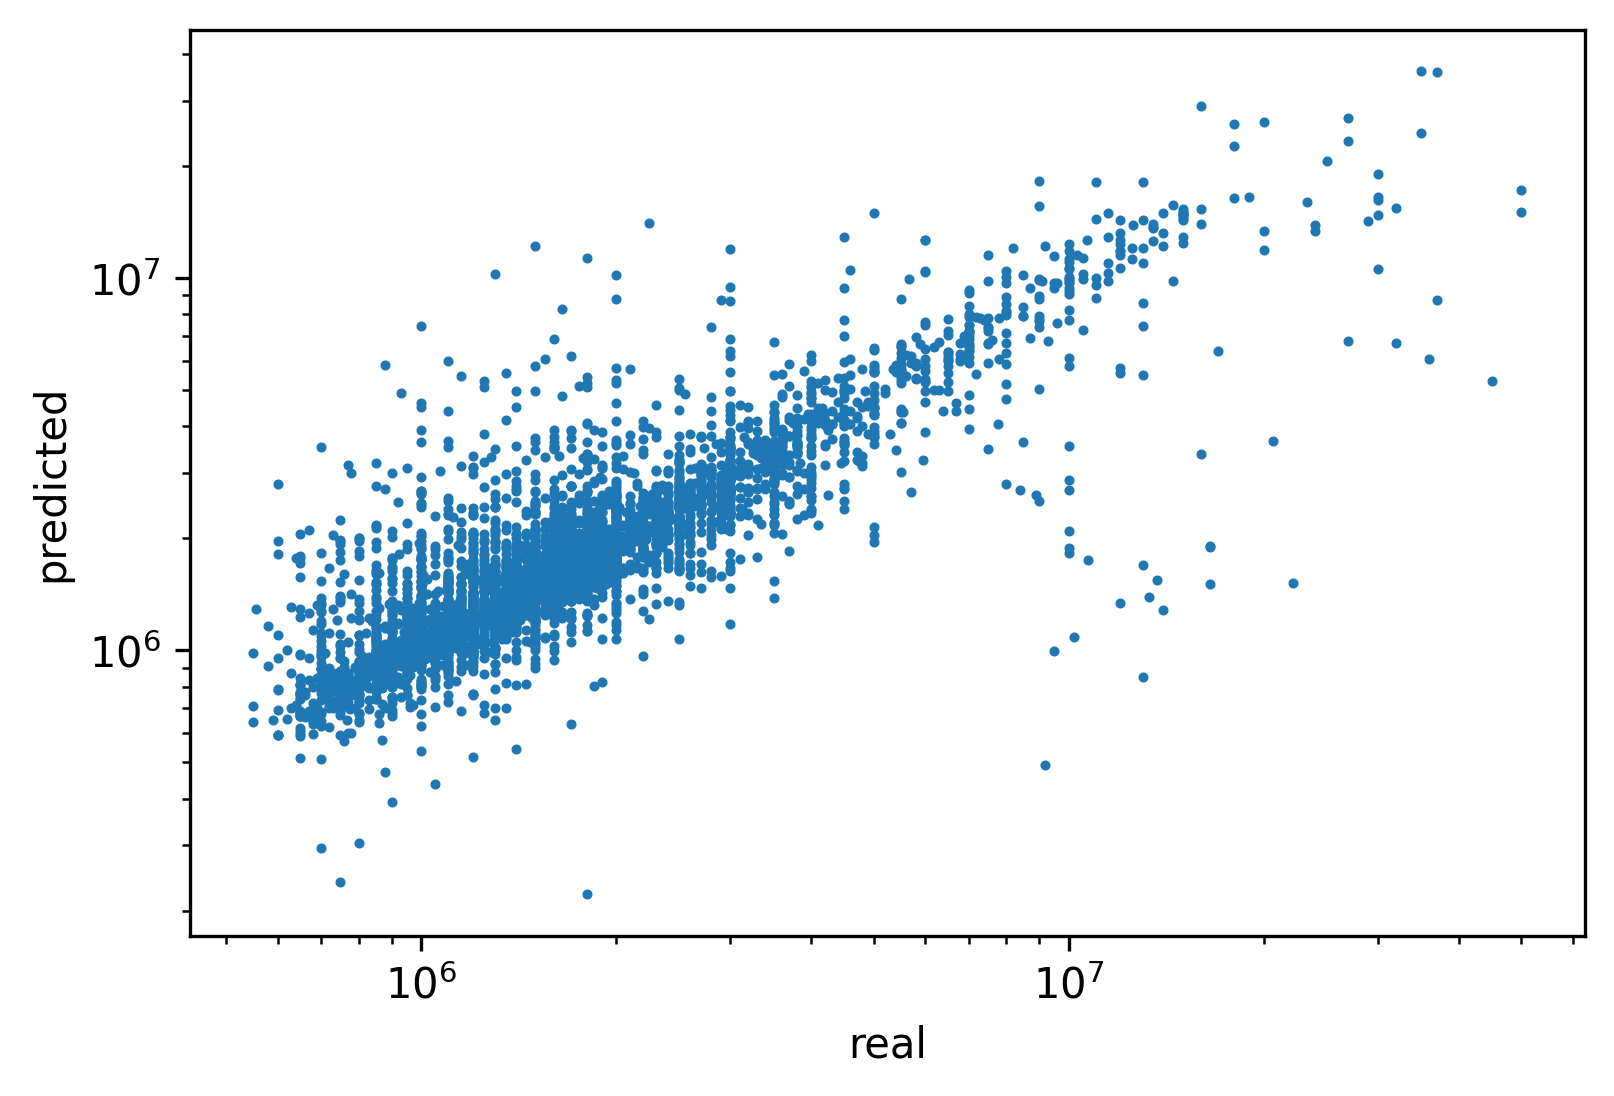

In [40]:
fig = plt.figure(dpi=300)
ax = fig.add_subplot(1, 1, 1)
ax.scatter(iter_res['real'], iter_res['prediction'], s=2)
ax.set_xscale('log')
ax.set_yscale('log')
ax.set_xlabel('real')
ax.set_ylabel('predicted')
fig.show()

<p><b>There is a group of outliers below the main trend. Looks like their price is enormous. We need deeper investigation to get whether we should remove them. In case this data is really incorrect then we should reeducate model without such data.</b></p>

In [41]:
best_xgb_model = XGBRegressor(gamma=0,                 
                 learning_rate=0.07,
                 max_depth=8,
                 min_child_weight=1.5,
                 n_estimators=100,                                                                    
                 reg_alpha=0.75,
                 reg_lambda=0.45,
                 subsample=0.8,
                 seed=42)
best_xgb_model.fit(train_x, train_y)

XGBRegressor(base_score=0.5, booster='gbtree', colsample_bylevel=1,
             colsample_bynode=1, colsample_bytree=1, gamma=0, gpu_id=-1,
             importance_type='gain', interaction_constraints='',
             learning_rate=0.07, max_delta_step=0, max_depth=8,
             min_child_weight=1.5, missing=nan, monotone_constraints='()',
             n_estimators=100, n_jobs=16, num_parallel_tree=1, random_state=42,
             reg_alpha=0.75, reg_lambda=0.45, scale_pos_weight=1, seed=42,
             subsample=0.8, tree_method='exact', validate_parameters=1,
             verbosity=None)

In [42]:
predicted_prices = best_xgb_model.predict(test_data)